# Exploring storing capabilities of Hyperdimensional Binary Vectors

In this notebook there's a simple implementation of a Hyperdimensional Computing system. We use the Semantic Pointer Architecture (SPA) using binary vectors for encoding semantic feature norms as proposed by McRae's dataset. 
This program explores the storing and retrieval capabilities of Hyperdimensional vectors, by asking the question: How many concepts can be stored and then retrieved within a binary vector.

In [143]:
# Header of the program
# Libraries
import numpy as np
import pandas as pd
import time

# Global variables
N = 10000 #10000      # Vectors' lenght
#ones = int(N*0.6931)  #Amount of ones in vector. With this value 50% of elements in vectors are ones (N = 1000 -> 0.694)
#N = 1000; ones = int(N*0.694)
ones = int(N*0.694)

Dict = {}     # Dictionary -> Symbols catalog
Dict_defs = {} # Definitions dictionary 
thr = 0.45 * N  #Similarity threshold

Memory = [[],[],[]]  # The entire associative memory. First row is symbols (HDvector object), second row is label (string),
                     # and third row is its definition, if it exists (HDvector object)

## General functions for vectors and auxiliary functions

In [144]:
# General functions for vectors
def SparseBitString(n):
    """This function generates a random binary vector
    n: length of vector
    BitString: Binary vector"""
    # Generates 'ones' different random numbers ranging from 0 to n-1
    Address = np.random.randint(0, n-1, ones)
    # Initialize binary vector
    BitString = np.zeros(n, dtype = np.int8)
    # Set to 1 the address generated
    BitString[Address] = 1
    return BitString

def ADD(*arg):
    " General function for vectors addition, it assumes that the argument is an object HDvector"
    if len(arg) == 1 and type(arg[0]) is list:
        arg = arg[0]
    len_0 = arg[0].lenght
    Sum = np.zeros(len_0) # Initialize sum vector
    n = len(arg) # Number of vectors to add
    for vec in arg:
        assert vec.lenght == len_0  # Are all dimensions equal??
        Sum = Sum + vec.vec         # 'normal' sum
    Sum = Sum / n                   # Average
    Sum[Sum > 0.5] = 1              #Thresholding
    Sum[Sum == 0.5] = SparseBitString(len_0)[Sum == 0.5]  # If average equal to 0.5 -> select a random value (0 or 1)
    return HDvector(Sum.astype(np.int8))

def flat_list (L):
    "Recursive function that flats a list of lists (at any level)"
    if L == []:
        return L
    if type(L[0]) is list:
        return flat_list(L[0]) + flat_list(L[1:])
    return L[:1] + flat_list(L[1:])

def flat_list_1l (L):
    "Flattens a list one level only"
    R = []
    for l in L:
        R.extend(l)
    return R

## A class for Hyperdimensional vectors

This class includes the initialization, getters and setters functions as well as Arithmetical operations for managing HD vectors

In [145]:
# Hyperdimensional vectors class
class HDvector (object):
    # We can initialize our vector with its content (array) or its length (content random)
    def __init__ (self, vec_or_len, label = None, pointer = None):
        global Memory   # We use global variable
        
        if type(vec_or_len) is int: # Initializing vector by lenght
            self.lenght = vec_or_len
            self.vec = SparseBitString(vec_or_len)
            
        elif type(vec_or_len) is np.ndarray:   # Initializing vector by content
            self.lenght = len(vec_or_len)
            self.vec = vec_or_len
            
        else:
            raise TypeError("Input has to be integer (length) or numpy array")
        
        # If a string label is given, the initialized vector is added in global catalogs
        if label in Memory[1]:
            raise NameError("Label '" + str(label) + "'is already in catalog!")
        elif label:
            Memory[1].append(label)
            Memory[2].append(pointer)
            if len(Memory[0]) != 0:
                Memory[0] = np.concatenate((Memory[0], self.vec.reshape((1,self.lenght))))  #it had N...
            Dict[label] = self   # label is linked to vector -> (added to global dictionary)
            
        self.label = label       # assigning vector label
        self.pointer = pointer   # assigning pointer (vector)
        
        # Index of this object in global Memory...
        self.index = len(Memory[0]) - 1
    
    
    # Getters
    def getVec(self):   # it returns the array of the HD vector object
        return self.vec
    
    
    def getLabelID (self, num = N): # return label, it can be its assigned label or a list of the 'num' closest vectors labels
        if self.label:  # if it has an assigned label
            return [[self.label, 0]]
        
        else: #This vector hasn't a label. We find the 'num' most similar vectors in dictionary return a list of them
            HamVec = np.array([self.dist_vec(x) for x in Memory[0]]) #Distance to all vectors in memory
            # Indices where HamVec[i] < similarity threshold
            Indices = np.where(HamVec < thr)[0]
            
            # Cutting list to 'num'
            #Indices = Indices[:num]
            
            # Result is a list of lists [label, distance]
            L = [[Memory[1][i], HamVec[i]] for i in Indices]
            # Sorting
            L = sorted(L, key = lambda r: r[1])
            return L[:num]  #choosing only first 'num'...     #sorted(L, key = lambda r: r[1])
                
    def getLabelSP(self, num = N):   #get label of vector by searching in definitions...
        # Collect indeces where there's an actual pointer vector...
        Index = [i for i,x in enumerate(Memory[2]) if type(x) == np.ndarray]
        HamVec = np.array([self.dist_vec(Memory[2][x]) for x in Index])
        Indices = np.where(HamVec < thr)[0]  # Indices below similarity threshold
        
        Indices = Indices[:num]
        
        #Result is a list of lsits [label,distance]
        L = [[Memory[1][Index[i]], HamVec[i]] for i in Indices]
        L = sorted(L, key = lambda r: r[1])
        return L[:num] #sorted(L, key = lambda r: r[1])
        
    def getPointer(self):
        return self.pointer
    
    # Setters
    def setContent(self, in_array): #Set a new content
        self.vec = in_array
    def setPointer(self, other):    #Set a vector to point to
        self.pointer = other
        Memory[2][self.index] = other.getVec()  #setting new vector..
    
    # Distance
    def dist(self, other):        #Measure distance between two object vectors
        assert self.lenght == other.lenght    #Sanity check
        return np.count_nonzero(self.vec != other.vec)
    def dist_vec(self, vecc):      #Measure distance between an object vector and a numpy array (sometimes useful)
        assert self.lenght == len(vecc)      #Sanity check
        return np.count_nonzero(self.vec != vecc)
    
    # Arithmetic 
    def p(self, times):     #Pemutation aka rolling
        return HDvector(np.roll(self.vec, times))
    def ip(self, times):    #Inverse permutation aka inverse rolling
        return HDvector(np.roll(self.vec, self.lenght - times))
    def __add__(self, other): #Add
        return ADD(self, other)
    def __mul__(self, other):  #Multiplication
        return HDvector( np.bitwise_xor(self.vec, other.vec))
    def __pow__(self, other):  #Function that multiplies self's pointer by other's vector
        if isinstance(self.getPointer(), HDvector):
            return HDvector(np.bitwise_xor(self.getPointer().getVec(), other.vec))

    # Other functions
    def conc (self, other):  #Concatenate two vector objects arrays
        return HDvector(np.concatenate((self.vec, other.vec)))
    def __str__(self):
        return str(self.vec)

## Memory initialization function

In [146]:
def init():
    "Initialize vector 'null' and symbol matrix"
    global Dict, Memory, Dict_defs
    Dict = {}; Memory = [[],[],[]]; feature_vectors = []
    
    thr = 0.45 * N  # Initial similarity threshold (later changed)
    # Null vector 
    null = HDvector(N, 'null')  # Initialize by size and label
    # Store vector in global array, this has to be done only once...
    Memory[0] = np.array([null.getVec()])
    
    # Definitions Dictionary...
    Dict_defs = {'apple': ['is_red','a_fruit','grows_on_trees','is_green','eaten_in_pies',
                'is_crunchy','has_seeds','is_juicy','tastes_sweet','is_round',
                'is_delicious','is_nutritious','is_yellow','has_a_core','has_skin',
                'tastes_sour','used_for_cider','eg_-_granny_smith','is_worm_infested',
                'used_for_cooking', 'worn_for_protection', 'made_of_cloth','has_strings',
                'worn_for_covering_clothes', 'worn_in_kitchens', 'made_of_cotton',
                'associated_with_angels', 'associated_with_babies', 'beh_-_eats_fish',
                'beh_-_eats_nuts', 'is_wall_to_wall','is_warm','lives_by_the_ocean',
                'lives_in_a_colony', 'made_by_oysters','made_from_dried_grapes',
                'requires_a_license','requires_air','smells_bad', 'symbol_of_freedom',
                'used_at_Easter','used_on_walls','used_with_tea_cups','worn_with_skirts',
                'used_underwater','used_when_people_are_ill','used_in_alcoholic_drinks','used_in_autumn',
                'is_attached_to_chains','is_attached_to_ropes','beh_-_climbs_trees','beh_-_clucks',
                'eg_-_wood','eg_weeping','found_at_bus_stops','has_8_tentacles','has_a_back','has_a_bag',
                'has_wings','herded_by_shepherds','hunted_by_people','worn_over_clothes','used_in_autumn',
                'used_as_a_gift','owned_by_companies','lives_near_water','lives_on_lily_pads',
                'becomes_a_butterfly','causes_bad_breath','causes_cancer']}

## Memory functions (writing)

In [147]:
def SaveConcepts(Dic):
    """Given a definitions dictionary it stores in memory the entire set of concepts in the dictionary (including feature vectors)"""
    keys = Dic.keys()
    vals = Dic.values()
    all_concepts = list(set(flat_list(vals) + keys))
    # Process for storing list of concepts in memory
    for concept in all_concepts:
        HDvector(N,concept) #This creates an object and store it in memory

def FeatureVectors(Dic):
    global feature_vectors
    featt = []
    vals = Dic.values()
    for l in vals:
        for p in l:
            featt.append(p[0])
    feature_vectors = list(set(featt))
            
def CreateSemanticPointer (PairList):
    "Turns list as [[feat1,feat_val],[feat2,feat_val],[feat3,feat_val]] into vector feat1*feat_val + feat2*feat_val ..."
    vecs = []
    for pair in PairList:
        vecs.append(Dict[pair[0]] * Dict[pair[1]])
    return ADD(vecs)
        
def SaveDefinitions(Dic):
    """Given the definitions dictionary, and having all its concepts previously stored in memory, this functions
       creates a definition vector (semantic pointer) using HD operations and assign it as a pointer to an 
       object vector (ID vector)."""
    global Dict #decía -> feature_vectors
    # Going through all elements in dictionary
    for key, value in Dic.iteritems():
        Dict[key].setPointer(CreateSemanticPointer(value))

## Memory functions (reading)

In [148]:
def RetrieveDef (HDvec):
    "This function extract all feat_values from a given vector and returns a list of its labels"
    R = []
    for feat_vec in feature_vectors: #feature_vectors is a global variable...
        feat_val = HDvec * Dict[feat_vec]
        R.append(feat_val.getLabelID())
    return R


def DistanceOnevsAll (label):
    "This functions measure the average and max distance from HDvec to all other vectors in memory"
    D = []
    for elem in Dict:
        if elem != label:
            D.append(Dict[label].dist(Dict[elem]))

    return [round(sum(D) / float(len(D)),2), max(D), min(D)]

def DistanceAllvsAll ():
    R = []
    for elem in Dict:
        R.append(DistanceOnevsAll(elem))
    Avg = [x[0] for x in R]
    Max = [x[1] for x in R]
    Min = [x[2] for x in R]
    return [round(sum(Avg) / float(len(Avg)),2), max(Max),min(Min)]

## Excel managing functions

This functions reads an excel file called FEATS_brm from the McRae's dataset to translate feature names such as "is_red" into a python list like [is, red]. 
This is going to be used for encoding each concept into hyperdimensional vectors by means of arithmetical operations like concept = is * red + ...

In [149]:
def TranslateFeats(ListFeat):
    " It receives a list of features such as ['is_blue', 'is_rectangular'] and it returns the same list translated to pairs of feat_name and feat_value: [['color','blue'], ['shape','rectangular'] "
    # Dataframe for excel document
    df = pd.read_excel('../McRaedataset/FEATS_brm.xlsx')
    ListPairs = []
    for feat in ListFeat:
        # Row for feature...
        row = df.loc[df['Feature'] == feat]       
        # Look for values in vec_feat and vec_value
        ListPairs.append([str(row['feat_name'].tolist()[0]), str(row['feat_value'].tolist()[0])])       
    return ListPairs

## Definitions dictionary functions

Here we define a dictionary with the definition of a single concept (from McRae's dataset)

In [150]:
def format_dict (Dic, num_features):
    global Dict_defs
    # Format dictionary
    for x in Dic:
        Dict_defs[x] = TranslateFeats(Dict_defs[x][0:num_features])

## Main Function

In [151]:
def EncodingTest(num_features):
    # Initialization
    init()
    #Giving format to dictionary -> change original feature names for list [feat_name, feat_value]
    format_dict(Dict_defs, num_features)
    
    # List of feature names
    FeatureVectors(Dict_defs)
    # Save each individual concept into memory
    SaveConcepts(Dict_defs)
    # Assign a semantic pointer to defined concepts
    SaveDefinitions(Dict_defs)
#    print 'Feature vectors:', feature_vectors,'\n'
    
    # Measuring distance between all vectors...
    DistList = DistanceAllvsAll()
#    print "Average, Max and Min distance all vs all:", DistList

    # New similarity threshold
    thr = int( 0.94 * DistList[2] )
#    print "\nSimilarity Threshold:", thr
    
    
    # Retrieving feature values from definition in memory
    start = time.time()
    Feat = RetrieveDef(Dict['apple'].getPointer())
    end = time.time()
    
#    print "\nTime elapsed: ", time.time() - start
    
    Feat = flat_list_1l (Feat) # flatting one level
#    print "\nRetrieved list:\n", Feat

    # Evaluating result...
    # Filtering feature values from the definition list in global dictionary
    def_list = [x[1] for x in Dict_defs['apple']]
    
    # Filtering feature values from obtained list
    feat_val_list = [x[0] for x in Feat]
    
#    print "\n# of features in definition:", len(def_list)
    # Percentage of successfully retrieved features
    success = round(len(set(def_list).intersection(set(feat_val_list))) / float( len(def_list) )*100, 2)    
#    print "\nSuccessfully retrieved features:",success, "%" 
    
    # List of distances (from retrieved vectors to original vectors in memory)
    Dists_list = [x[1] for x in Feat]
    
    # Average distance
    avg = round( sum(Dists_list) / float(len(Dists_list)), 2)
#    print "\nAverage distance (from retrieved vector to stored ID vector):", avg
    
    # Max distance
#    print "\nMax distance (but smaller than threshold):", max(Dists_list)
    
    return [num_features,end-start, success, avg, max(Dists_list)]

    # Resolver lo que sea necesario para no tener que volver a correr el programa cada vez...
    
    # Hacer pruebas con el límite de 'compresión', es decir, probar con definiciones largas y ver si aun se recupera bien
    # la información... puedo incluso hacer tablas de eso... mi umbral de 0.45 es adecuado??
    
    # Tampoco estaría mal hacer un programa que haga una matriz de distancias de todos los semantic pointers contra los demás...
    
    # Sería interesante probar la codificación de un grafo según gayler:  G = A * P(B) + A * P(C) + B * P(D)
    # (si el vector es permutado es hijo, el no permutado es padre)
    # ¿qué ventajas hay?, se ve que es más sencillo pero quien sabe que desventajas tenga....

def Main ():
    R = []
    for num in [1] + list(range(5,71,5)):
        R.append(EncodingTest(num))
    return R

Table = Main()
#print Table

Plot:


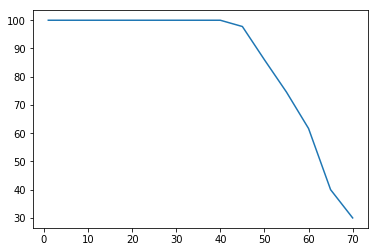

In [153]:
import matplotlib.pyplot as plt

%matplotlib inline

# Number of features
x = np.array([t[0] for t in Table])

# Successful retrieval (%)
y = np.array([t[2] for t in Table])

plt.plot(x, y)
print "Plot:"